In [1]:
import tensorflow as tf
import tf_util
import numpy as np
import pickle
import os
import time
from matplotlib import pyplot as plt
import gym
import random
import mujoco_py
import load_policy

%load_ext autoreload
%autoreload 2

def set_seed(seed_number):
    os.environ['PYTHONHASHSEED']=str(seed_number)
    random.seed(seed_number)
    np.random.seed(seed_number)
    tf.set_random_seed(seed_number)
    
def split_data(data):
    x, y = data['observations'], data['actions']
    n = x.shape[0]
    arr = np.arange(n)
    np.random.shuffle(arr)
    x, y = data['observations'][arr], data['actions'][arr]
    x_train, y_train = x[:int(0.6*n)], y[:int(0.6*n)]
    x_val, y_val = x[int(0.6*n):int(0.8*n)], y[int(0.6*n):int(0.8*n)]
    x_test, y_test = x[int(0.8*n):], y[int(0.8*n):]
    return x_train, y_train, x_val, y_val, x_test, y_test

def get_session(): # use with get_session() as sess: or sess = get_session()
    tf.reset_default_graph()
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

# Behavior cloning

#### 0. setup function

In [2]:
def load_split_data(data, game):
    # load experts data
    with open('./expert_data/'+str(data)+'.pkl', 'rb') as handle:
        human = pickle.load(handle)
    #print('observation', human['observations'].shape)
    #print('action', human['actions'].shape)
    #print()
    #print('observation example \n', human['observations'][0])
    #print('action example \n', human['actions'][0])
    x_train, y_train, x_val, y_val, x_test, y_test = split_data(human)
    
    env = gym.make(game)
    num_action = len(env.action_space.sample())
    num_state = env.reset().shape[0]
    return x_train, y_train, x_val, y_val, x_test, y_test, num_action, num_state

In [39]:
# define mlp nets
def model(state_dim, action_dim):
    state = tf.placeholder(tf.float32, [None, state_dim])
    action = tf.placeholder(tf.float32, [None, 1, action_dim])
    """
    with tf.variable_scope('conv'):
        conv1 = tf.contrib.layers.conv2d(state, num_outputs = 32, kernel_size = 8, stride = 4)
        conv2 = tf.contrib.layers.conv2d(conv1, num_outputs = 64, kernel_size = 4, stride = 2)
        conv3 = tf.contrib.layers.conv2d(conv2, num_outputs = 64, kernel_size = 3, stride = 1)
                
    conv3_flatten = tf.contrib.layers.flatten(conv3)
    """            
    if state_dim > 100:
        with tf.variable_scope('fc'):
            fc1 = tf.layers.batch_normalization(tf.contrib.layers.fully_connected(state, 1024))
            fc2 = tf.layers.batch_normalization(tf.contrib.layers.fully_connected(state, 1024))
            fc3 = tf.layers.batch_normalization(tf.contrib.layers.fully_connected(state, 1024))
            fc3 = tf.layers.batch_normalization(tf.contrib.layers.fully_connected(state, 1024))
            fc4 = tf.layers.batch_normalization(tf.contrib.layers.fully_connected(state, 512))
            fc5 = tf.layers.batch_normalization(tf.contrib.layers.fully_connected(state, 256))
            out = tf.contrib.layers.fully_connected(fc4, action_dim, activation_fn=None)   
    else:
        with tf.variable_scope('fc'):
            fc1 = tf.contrib.layers.fully_connected(state, 1024)
            fc2 = tf.contrib.layers.fully_connected(state, 1024)
            fc3 = tf.contrib.layers.fully_connected(state, 1024)
            out = tf.contrib.layers.fully_connected(fc2, action_dim, activation_fn=None)           
    
    out = tf.reshape(out, [tf.shape(state)[0], 1, action_dim])
    return state, action, out

def loss_function(pred, label):
    loss = tf.losses.mean_squared_error(pred, label)
    return loss

def optimizer(loss, lr = 1e-4):
    train_step = tf.train.AdamOptimizer(lr, epsilon=1e-4).minimize(loss)
    return train_step

In [4]:
# train nn
def train_nn(seed, num_state, sess, num_action, it_num, batch_size, batch_size2, 
             epoch, x_train, y_train, x_val, y_val, x_test, y_test, plot = True, lr = None, verbose = True):
    set_seed(1)
    
    state, action, out = model(num_state, num_action)
    mean_loss = loss_function(out, action)
    train_step = optimizer(mean_loss)
    
    var= tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    sess.run(tf.global_variables_initializer())    
    
    for i in range(epoch):
        loss_his, loss_his2, loss_his3 = [], [], []
        for j in range(int(x_train.shape[0]/batch_size)):
            _, loss_train = sess.run([train_step, mean_loss], feed_dict={state:x_train[j*batch_size:(j+1)*batch_size]
                                                                                , action:y_train[j*batch_size:(j+1)*batch_size]})
            loss_his.append(loss_train)
        
            loss_val = sess.run([mean_loss], feed_dict={state:x_val[j*batch_size2:(j+1)*batch_size2]
                                                                                , action:y_val[j*batch_size2:(j+1)*batch_size2]})
            loss_test = sess.run([mean_loss], feed_dict={state:x_test[j*batch_size2:(j+1)*batch_size2]
                                                                                , action:y_test[j*batch_size2:(j+1)*batch_size2]})
            loss_his2.append(loss_val)
            loss_his3.append(loss_test)
        
        if verbose:
            print('\n'+str(i)+' epoch: '+'train loss', loss_train)
            print('val loss: '+ str(np.mean(np.array(loss_his2)))+' test loss: ',str(np.mean(np.array(loss_his3))) )
        if plot and i % 10 == 0:
            plt.plot(loss_his)
            plt.title('Loss train')
            plt.show()
            
    return sess, state, action, out

In [5]:
# evaluate policy of trained agent
def eval_policy(game, num_rollouts, sess, state, out, env, verbose = True, render = False, data_gen = False):
    returns = []
    
    for i in range(num_rollouts):
        steps = 0
        obs = env.reset()
        if i == 0 and data_gen:
            data_pi = obs.reshape(1, -1)
        done = False
        totalr = 0

        while not done:
            action = sess.run(out, feed_dict={state:obs.reshape(1, -1)})
            obs, r, done, _ = env.step(action)
            if data_gen:
                data_pi = np.concatenate([data_pi, obs.reshape(1,-1)])
            totalr += r
            steps += 1
            if render:
                env.render()
        returns.append(totalr)
        if verbose:
            print('\niter', i)
            print('mean return', np.mean(returns))
            print('std of return', np.std(returns))
        else:
            if i == num_rollouts-1:
                print('mean return', np.mean(returns))
                print('std of return', np.std(returns))
    
    if data_gen:
        return returns, data_pi
    else:
        return returns

#### 1. HalfCheetah

observation (100000, 17)
action (100000, 1, 6)

observation example 
 [-0.02033121  0.06750765 -0.0578007  -0.07536742 -0.06343042 -0.02833271
 -0.02037377 -0.06787478  0.00838537  0.10618275  0.1457029  -0.17950187
  0.096978   -0.1579786  -0.08390649 -0.06582695  0.03371656]
action example 
 [[ 0.05203422  0.61691374 -0.9345577   0.7927394   0.2631963   0.10855416]]
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.

0 epoch: train loss 0.048844807
val loss: 0.11015327 test loss:  0.9969691


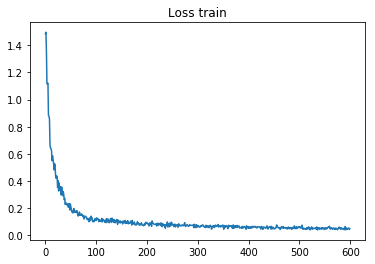


1 epoch: train loss 0.03186901
val loss: 0.038897507 test loss:  1.0486764

2 epoch: train loss 0.025142366
val loss: 0.028347753 test loss:  1.0624768

3 epoch: train loss 0.02138446
val loss: 0.02308547 test loss:  1.0702846

4 epoch: train loss 0.018909222
val loss: 0.019827003 test loss:  1.07529

5 epoch: train loss 0.017117556
val loss: 0.017496862 test loss:  1.0787938

6 epoch: train loss 0.015694983
val loss: 0.015711939 test loss:  1.0814825

7 epoch: train loss 0.014427667
val loss: 0.014290466 test loss:  1.0834967

8 epoch: train loss 0.013330912
val loss: 0.0131365955 test loss:  1.0851756

9 epoch: train loss 0.01237272
val loss: 0.012177383 test loss:  1.0866277

10 epoch: train loss 0.011585579
val loss: 0.011369458 test loss:  1.0878508


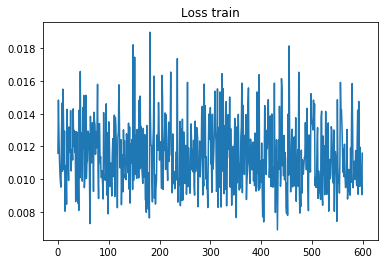


11 epoch: train loss 0.010909028
val loss: 0.010680187 test loss:  1.0889237

12 epoch: train loss 0.010319751
val loss: 0.010083873 test loss:  1.089857

13 epoch: train loss 0.009791179
val loss: 0.009565881 test loss:  1.0907073

14 epoch: train loss 0.009372994
val loss: 0.009107452 test loss:  1.0914204

15 epoch: train loss 0.008964133
val loss: 0.008700065 test loss:  1.0920506

16 epoch: train loss 0.008556507
val loss: 0.008338826 test loss:  1.0926269

17 epoch: train loss 0.008224463
val loss: 0.008012897 test loss:  1.0931394

18 epoch: train loss 0.007922079
val loss: 0.007717022 test loss:  1.0935924

19 epoch: train loss 0.0076276376
val loss: 0.00744702 test loss:  1.0939962

20 epoch: train loss 0.0073460652
val loss: 0.007200303 test loss:  1.0943619


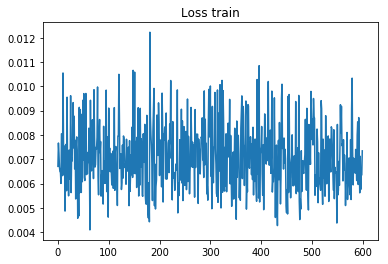


21 epoch: train loss 0.007048464
val loss: 0.0069723097 test loss:  1.0946891

22 epoch: train loss 0.00680396
val loss: 0.0067605623 test loss:  1.0949808

23 epoch: train loss 0.0065852827
val loss: 0.006564352 test loss:  1.0952562

24 epoch: train loss 0.006371486
val loss: 0.0063825045 test loss:  1.0955119
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [20]:
# split data, create env
data = 'HalfCheetah-v22'
game = 'HalfCheetah-v2'
x_train, y_train, x_val, y_val, x_test, y_test, num_action, num_state = load_split_data(data, game)

# training deep neural nets
seed = 1
set_seed(seed)
sess = get_session()
it_num = int(1e+5)
batch_size = 100
batch_size2 = int(batch_size/3)
epoch = 25
sess, state, action, out = train_nn(seed, num_state, sess, num_action, it_num, batch_size, batch_size2, epoch, x_train, y_train, x_val, y_val, x_test, y_test)

# evaluate policy of trained agent
env = gym.make(game)
num_rollouts = 100
returns = []
returns = eval_policy(game, num_rollouts, sess, state, out)

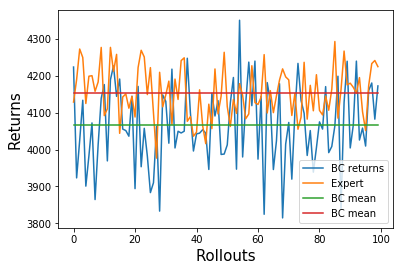

<Figure size 432x288 with 0 Axes>

In [22]:
# plot returns of BC and experts
plt.plot(returns, label = 'BC returns')
plt.xlabel('Rollouts', size=15)
plt.ylabel('Returns',size =15)
expert = [4128.728383502425, 4189.535684673227, 4272.43303667612, 4249.560423016207, 4124.772769049202, 4198.7097924364125, 4200.1419735573745, 4157.776701879373, 4183.002617459517, 4276.806235453813, 4091.9185494035255, 4110.495515510108, 4276.9212743364515, 4211.965179413419, 4257.969935553734, 4043.885796969095, 4142.499163256315, 4150.679691581168, 4112.035436378099, 4144.082152181334, 4088.0712633445924, 4222.320207777014, 4269.064293269311, 4250.906939027812, 4148.951248388147, 4222.023925064402, 4098.925831355091, 3976.6875579460834, 4209.380638842714, 4115.734884418981, 4147.831670044442, 4185.394716315659, 4067.801853424089, 4190.939196720014, 4135.750687511855, 4241.12220146413, 4248.600645493026, 4076.5123996714224, 4089.116529174026, 4036.020140445872, 4047.0686695754534, 4161.7820300860285, 4064.3324558793024, 4015.9265603773433, 4122.9001866605395, 4056.6786930649814, 4218.364321840599, 4096.500474489058, 4144.684147770466, 4263.584984166652, 4116.606466006029, 4062.521071746634, 4135.656341300057, 4097.933123609351, 4178.558245317028, 4146.867606323324, 4083.399670997339, 4096.388304382819, 4227.133001891338, 4127.106261158067, 4122.227998151923, 4141.7516718342695, 4257.282575178695, 4099.169477649469, 4159.645790167006, 4099.959176133804, 4145.190574195959, 4188.549485786253, 4218.614841959601, 4196.916768206129, 4188.857668924531, 4092.3066926686647, 4152.206825351386, 4054.9296687822607, 4087.5672154644267, 4236.416859209656, 4082.4200891082974, 4174.03411470297, 4104.986535282874, 4202.833953389136, 4106.019843779324, 4093.815304044671, 4145.191533113684, 4106.467003824522, 4163.7244443784775, 4292.848002944813, 4085.0320479459824, 4161.563694890181, 4266.924476517376, 4175.447192583615, 4179.846330812467, 4168.484682905271, 4152.822904171786, 4194.979992335082, 4102.46226750325, 4051.3197245830893, 4173.358193314855, 4232.962184045349, 4241.348806201747, 4224.688252340227]
plt.plot(expert,label = 'Expert')
plt.plot(np.mean(returns)*np.ones((100,)), label = 'BC mean')
plt.plot(np.mean(expert)*np.ones((100,)), label = 'BC mean')
plt.legend()
plt.figure()
plt.show()

In [34]:
# performance w.r.t learning rate

# split data, create env
data = 'HalfCheetah-v22'
game = 'HalfCheetah-v2'
x_train, y_train, x_val, y_val, x_test, y_test, num_action, num_state = load_split_data(data, game)

# training deep neural nets
seed = 1
set_seed(seed)
it_num = int(1e+5)
batch_size = 100
batch_size2 = int(batch_size/3)
epoch = 25
lr_list = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
return_list = []
for i in lr_list:
    sess = get_session()
    sess, state, action, out = train_nn(seed, num_state, sess, num_action, it_num, batch_size, batch_size2, epoch, x_train,
                                        y_train, x_val, y_val, x_test, y_test, lr = i, plot = False, verbose = False)

    # evaluate policy of trained agent
    env = gym.make(game)
    num_rollouts = 25
    returns = []
    returns = eval_policy(game, num_rollouts, sess, state, out, verbose = False)
    return_list.append(returns)

observation (100000, 17)
action (100000, 1, 6)

observation example 
 [-0.02033121  0.06750765 -0.0578007  -0.07536742 -0.06343042 -0.02833271
 -0.02037377 -0.06787478  0.00838537  0.10618275  0.1457029  -0.17950187
  0.096978   -0.1579786  -0.08390649 -0.06582695  0.03371656]
action example 
 [[ 0.05203422  0.61691374 -0.9345577   0.7927394   0.2631963   0.10855416]]
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.

0 epoch: train loss 0.048844803
val loss: 0.11015327 test loss:  0.996969

1 epoch: train loss 0.03186901
val loss: 0.038897507 test loss:  1.0486764

2 epoch: train loss 0.02514236
val loss: 0.028347747 test loss:  1.0624768

3 epoch: train loss 0.021391824
val loss: 0.023085736 test loss:  1.0702851

4 epoch: train loss 0.018910933
val loss: 0.019827193 test loss:  1.0752928

5 epoch: train loss 0.017104033
val loss: 0.01749


5 epoch: train loss 0.017117452
val loss: 0.017496223 test loss:  1.078794

6 epoch: train loss 0.015689442
val loss: 0.015712267 test loss:  1.0814809

7 epoch: train loss 0.014425494
val loss: 0.014290081 test loss:  1.0834992

8 epoch: train loss 0.013329611
val loss: 0.013137406 test loss:  1.0851763

9 epoch: train loss 0.012374604
val loss: 0.012179365 test loss:  1.0866328

10 epoch: train loss 0.011575622
val loss: 0.011372047 test loss:  1.0878524

11 epoch: train loss 0.010901316
val loss: 0.010682818 test loss:  1.0889193

12 epoch: train loss 0.010315658
val loss: 0.010086242 test loss:  1.0898527

13 epoch: train loss 0.009780888
val loss: 0.00956828 test loss:  1.090705

14 epoch: train loss 0.009358102
val loss: 0.009108718 test loss:  1.0914214

15 epoch: train loss 0.008945072
val loss: 0.008701352 test loss:  1.0920546

16 epoch: train loss 0.008556118
val loss: 0.008339734 test loss:  1.0926191

17 epoch: train loss 0.00821153
val loss: 0.008013638 test loss:  1.093

In [36]:
# print mean and std of return of 25 number of simulations
for i in return_list:
    print(np.mean(i), np.std(i))

4042.3781129026493 135.58652892792512
4035.862748085297 122.70289985368629
4064.313364289852 86.37894634894374
4049.7833811827113 104.68512829328776
4045.765394144802 114.08333693152503


#### 2. Humanoid-v2

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.

0 epoch: train loss 4.9452643
val loss: 63.331875 test loss:  58.58255


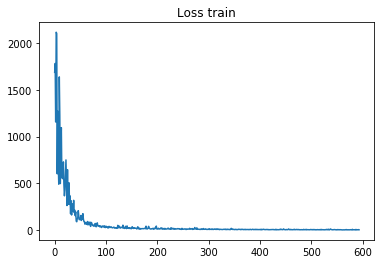


1 epoch: train loss 2.4361362
val loss: 3.5477152 test loss:  3.6655426

2 epoch: train loss 1.663626
val loss: 2.005354 test loss:  2.06916

3 epoch: train loss 1.221891
val loss: 1.3987638 test loss:  1.4571009

4 epoch: train loss 0.96425116
val loss: 1.0737532 test loss:  1.1323575

5 epoch: train loss 0.8360943
val loss: 0.8707179 test loss:  0.92863184

6 epoch: train loss 0.74409163
val loss: 0.7326227 test loss:  0.7884017

7 epoch: train loss 0.65539336
val loss: 0.6334632 test loss:  0.68659556

8 epoch: train loss 0.5466909
val loss: 0.5570797 test loss:  0.6074816

9 epoch: train loss 0.4892939
val loss: 0.49478313 test loss:  0.5421215

10 epoch: train loss 0.44704485
val loss: 0.44394127 test loss:  0.48790434


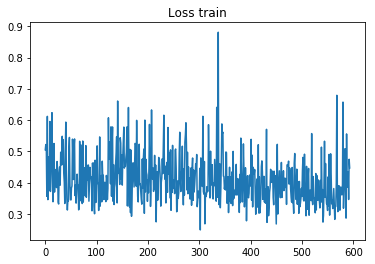


11 epoch: train loss 0.42878446
val loss: 0.40416914 test loss:  0.44573015

12 epoch: train loss 0.42394587
val loss: 0.37021852 test loss:  0.40932122

13 epoch: train loss 0.4255518
val loss: 0.34178376 test loss:  0.37762251

14 epoch: train loss 0.38490117
val loss: 0.3202074 test loss:  0.3529524

15 epoch: train loss 0.3456622
val loss: 0.2985621 test loss:  0.32944888

16 epoch: train loss 0.32489368
val loss: 0.28066656 test loss:  0.30972376

17 epoch: train loss 0.30013606
val loss: 0.26306403 test loss:  0.29077068

18 epoch: train loss 0.26836756
val loss: 0.25220865 test loss:  0.27703318

19 epoch: train loss 0.25454354
val loss: 0.23595737 test loss:  0.26286224

20 epoch: train loss 0.23541777
val loss: 0.22875376 test loss:  0.2519676


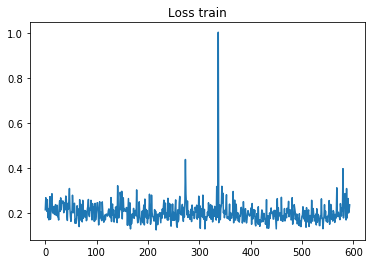


21 epoch: train loss 0.21199836
val loss: 0.21894449 test loss:  0.24116218

22 epoch: train loss 0.20401062
val loss: 0.20683967 test loss:  0.23113556

23 epoch: train loss 0.20352443
val loss: 0.20053317 test loss:  0.22310096

24 epoch: train loss 0.20000908
val loss: 0.19411443 test loss:  0.21484177

25 epoch: train loss 0.20468637
val loss: 0.18665923 test loss:  0.20899482

26 epoch: train loss 0.20521696
val loss: 0.18152066 test loss:  0.20270506

27 epoch: train loss 0.20086247
val loss: 0.17719278 test loss:  0.197688

28 epoch: train loss 0.20580938
val loss: 0.16741398 test loss:  0.18880281

29 epoch: train loss 0.20779131
val loss: 0.16559769 test loss:  0.18683797

30 epoch: train loss 0.18655625
val loss: 0.16241255 test loss:  0.18160251


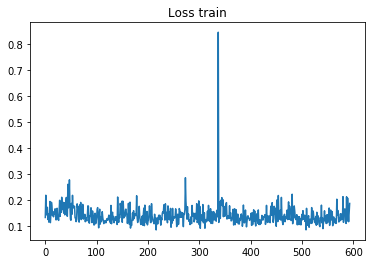


31 epoch: train loss 0.2239655
val loss: 0.15862307 test loss:  0.18051533

32 epoch: train loss 0.20577304
val loss: 0.15445401 test loss:  0.17442043

33 epoch: train loss 0.19679742
val loss: 0.15036379 test loss:  0.17183508

34 epoch: train loss 0.20984592
val loss: 0.14515674 test loss:  0.16492699

35 epoch: train loss 0.19845037
val loss: 0.14361537 test loss:  0.16640359

36 epoch: train loss 0.18686287
val loss: 0.1421612 test loss:  0.16164966

37 epoch: train loss 0.19216794
val loss: 0.13776457 test loss:  0.15983932

38 epoch: train loss 0.18969473
val loss: 0.13759013 test loss:  0.15638553

39 epoch: train loss 0.17214894
val loss: 0.13180889 test loss:  0.153653

40 epoch: train loss 0.18760845
val loss: 0.1308918 test loss:  0.15043706


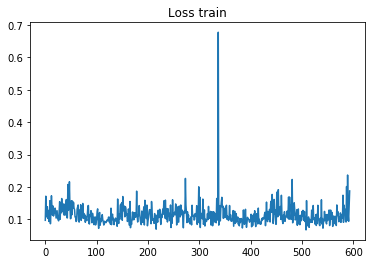


41 epoch: train loss 0.15603758
val loss: 0.12955256 test loss:  0.1491229

42 epoch: train loss 0.1669487
val loss: 0.128073 test loss:  0.14671853

43 epoch: train loss 0.18348858
val loss: 0.12754652 test loss:  0.14601938

44 epoch: train loss 0.16263723
val loss: 0.12361077 test loss:  0.14287148

45 epoch: train loss 0.17405616
val loss: 0.11985767 test loss:  0.14074299

46 epoch: train loss 0.14766231
val loss: 0.122163996 test loss:  0.14049512

47 epoch: train loss 0.14681965
val loss: 0.11932648 test loss:  0.13802479

48 epoch: train loss 0.18932927
val loss: 0.11581549 test loss:  0.13520345

49 epoch: train loss 0.15352255
val loss: 0.11735346 test loss:  0.13573223
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.

iter 0
mean return 1212.7861429685215
std of return 0.0

iter 1
mean return 959.4850278605036
std of return 253

In [40]:
# split data, create env
data = 'Humanoid-v2'
game = 'Humanoid-v2'
x_train, y_train, x_val, y_val, x_test, y_test, num_action, num_state = load_split_data(data, game)

# training deep neural nets
seed = 1
set_seed(seed)
sess = get_session()
it_num = int(1e+5)
batch_size = 100
batch_size2 = int(batch_size/3)
epoch = 50
sess, state, action, out = train_nn(seed, num_state, sess, num_action, it_num, batch_size, batch_size2, epoch, x_train, y_train, x_val, y_val, x_test, y_test)

# evaluate policy of trained agent
env = gym.make(game)
num_rollouts = 25
returns = []
returns = eval_policy(game, num_rollouts, sess, state, out, env)

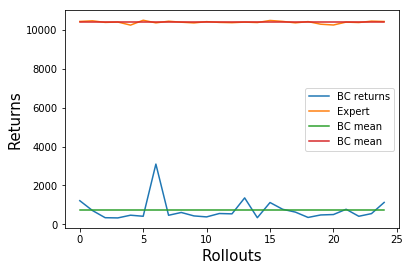

<Figure size 432x288 with 0 Axes>

In [41]:
# plot returns of BC and experts
plt.plot(returns, label = 'BC returns')
plt.xlabel('Rollouts', size=15)
plt.ylabel('Returns',size =15)
expert = [10438.186857983954, 10471.131848812303, 10389.244896091363, 10408.525369725054, 10249.73483750236, 10500.494293676069, 10365.63592228353, 10449.819812393624, 10399.94066843901, 10362.921788183248, 10427.754227585881, 10389.807021159531, 10375.111270627773, 10405.069458543141, 10381.935291587313, 10489.363191346045, 10440.62519389299, 10365.833474975829, 10430.640306509, 10295.54458154796, 10255.717391407743, 10405.162307972787, 10382.36730720193, 10454.536386206888, 10436.20845939734]
plt.plot(expert,label = 'Expert')
plt.plot(np.mean(returns)*np.ones((25,)), label = 'BC mean')
plt.plot(np.mean(expert)*np.ones((25,)), label = 'BC mean')
plt.legend()
plt.figure()
plt.show()

# DAgger

In [42]:
# define helper function for labeling
def label_data(game, data_pi):
    import tf_util
    policy_fn = load_policy.load_policy('./experts/'+ str(game)+'.pkl')
    action_list = []
    with tf.Session():
        tf_util.initialize()
        for idx, obs in enumerate(data_pi):
            action = policy_fn(obs[None,:])
            action_list.append(action)
    d_pi_action = np.array(action_list)
    return d_pi_action

# Define aggregation function
def aggregate(o1, a1, o2, a2):
    o = np.vstack((o1, o2))
    a = np.concatenate((a1, a2), axis = 0)
    
    # shuffle dataset
    n = o.shape[0]
    arr = np.arange(n)
    np.random.shuffle(arr)
    o, a = o[arr], a[arr]
    return o, a

obs (1, 376) (1, 376)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.

0 epoch: train loss 4.945266
val loss: 63.331875 test loss:  58.58255


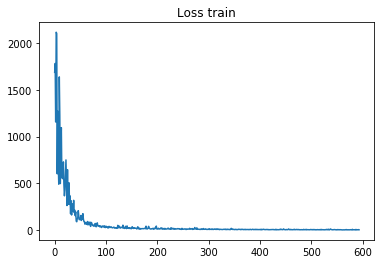


1 epoch: train loss 2.4361377
val loss: 3.5477152 test loss:  3.6655426

2 epoch: train loss 1.6636261
val loss: 2.005354 test loss:  2.06916

3 epoch: train loss 1.2218909
val loss: 1.3987637 test loss:  1.4571009

4 epoch: train loss 0.96419716
val loss: 1.0737578 test loss:  1.1323569

5 epoch: train loss 0.8361683
val loss: 0.8707183 test loss:  0.9286285

6 epoch: train loss 0.74427974
val loss: 0.73261464 test loss:  0.78837353

7 epoch: train loss 0.65490645
val loss: 0.63342994 test loss:  0.6865251

8 epoch: train loss 0.5448097
val loss: 0.5569955 test loss:  0.6073373

9 epoch: train loss 0.4905499
val loss: 0.494683 test loss:  0.54199946

10 epoch: train loss 0.4485317
val loss: 0.4440398 test loss:  0.48795038


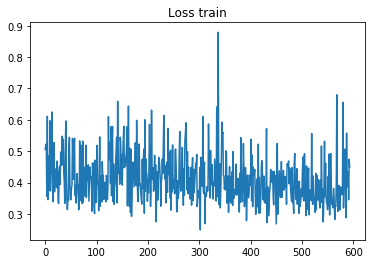


11 epoch: train loss 0.42920902
val loss: 0.40420035 test loss:  0.44611683

12 epoch: train loss 0.42553654
val loss: 0.37018493 test loss:  0.40895277

13 epoch: train loss 0.42478633
val loss: 0.34200993 test loss:  0.37843788

14 epoch: train loss 0.3856469
val loss: 0.3204558 test loss:  0.35301635

15 epoch: train loss 0.34686786
val loss: 0.29867867 test loss:  0.33046073

16 epoch: train loss 0.32489765
val loss: 0.28061953 test loss:  0.30937782

17 epoch: train loss 0.3009023
val loss: 0.2631949 test loss:  0.29228592

18 epoch: train loss 0.26539448
val loss: 0.25102082 test loss:  0.27526653

19 epoch: train loss 0.25093213
val loss: 0.23631783 test loss:  0.26474345

20 epoch: train loss 0.23102707
val loss: 0.22782677 test loss:  0.25088927


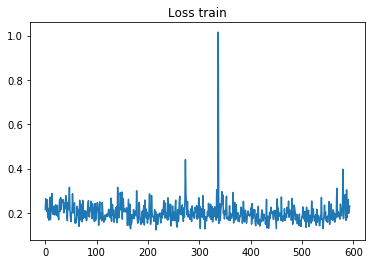


21 epoch: train loss 0.2101817
val loss: 0.21764073 test loss:  0.24201447

22 epoch: train loss 0.20437405
val loss: 0.20763421 test loss:  0.23034057

23 epoch: train loss 0.20590971
val loss: 0.19886868 test loss:  0.22453776

24 epoch: train loss 0.20165351
val loss: 0.19389343 test loss:  0.2144639

iter 0
mean return 358.8053755213022
std of return 0.0

iter 1
mean return 668.7070933168114
std of return 309.90171779550917

iter 2
mean return 562.7265939510279
std of return 294.0914522503388

iter 3
mean return 599.3049040951096
std of return 262.4523862227678

iter 4
mean return 592.8784922959981
std of return 235.09614863214358

iter 5
mean return 556.2059746158684
std of return 229.74522196639094

iter 6
mean return 543.0807656782969
std of return 215.11876742986934

iter 7
mean return 549.2300505206332
std of return 201.88182066863584

iter 8
mean return 538.872451843721
std of return 192.57734531501535

iter 9
mean return 526.5995654394281
std of return 186.3680342815122

it


iter 111
mean return 493.8166553709264
std of return 148.49338080173774

iter 112
mean return 492.23332719244326
std of return 148.78146670054008

iter 113
mean return 492.17644442997977
std of return 148.12871322812913

iter 114
mean return 492.484018300846
std of return 147.51982669761378

iter 115
mean return 491.80222803546644
std of return 147.06444618240653

iter 116
mean return 492.5729092068646
std of return 146.66968052170864

iter 117
mean return 495.3895175434614
std of return 149.190764444231

iter 118
mean return 496.89583099926665
std of return 149.4609742327316

iter 119
mean return 495.5246146664286
std of return 149.58668334887702

iter 120
mean return 494.4783065855904
std of return 149.40756351102618

iter 121
mean return 494.333249498276
std of return 148.8025327994332

iter 122
mean return 494.17415070774683
std of return 148.20682861422438

iter 123
mean return 494.05049492802226
std of return 147.61438135958215

iter 124
mean return 496.5448690727924
std of retu


iter 224
mean return 504.1952248163173
std of return 152.88288851944696

iter 225
mean return 503.90360518649027
std of return 152.6069818656085

iter 226
mean return 503.9069303335543
std of return 152.27048032964416

iter 227
mean return 504.00293471209864
std of return 151.9430719315989

iter 228
mean return 503.59834293127005
std of return 151.73399152752495

iter 229
mean return 503.0154031254723
std of return 151.66054795578754

iter 230
mean return 502.2651997931088
std of return 151.75900591185317

iter 231
mean return 502.3237871240313
std of return 151.43420388169238

iter 232
mean return 501.68211146134007
std of return 151.4246399876117

iter 233
mean return 501.42607246026944
std of return 151.1512724234471

iter 234
mean return 501.13528842860995
std of return 150.8949073938458

iter 235
mean return 501.0067772365675
std of return 150.58776232301616

iter 236
mean return 500.9580511802284
std of return 150.2715951533664

iter 237
mean return 500.261788179809
std of retur


iter 337
mean return 502.26953021989215
std of return 148.54519792670814

iter 338
mean return 501.6443827821082
std of return 148.77055786589813

iter 339
mean return 502.09213504423303
std of return 148.78019425067126

iter 340
mean return 502.5631334325488
std of return 148.8155166636009

iter 341
mean return 502.4465202502644
std of return 148.61339299871216

iter 342
mean return 502.6829939865377
std of return 148.4610206836592

iter 343
mean return 503.67645583165654
std of return 149.38250373419734

iter 344
mean return 503.2928754306305
std of return 149.33541089948912

iter 345
mean return 502.784241396276
std of return 149.41842411159718

iter 346
mean return 502.5100461575543
std of return 149.2901172954207

iter 347
mean return 502.69465633879827
std of return 149.11512514943072

iter 348
mean return 502.58070431476744
std of return 148.91651295383696

iter 349
mean return 502.49987675406635
std of return 148.71128913134106

iter 350
mean return 503.82725667403736
std of r


iter 450
mean return 500.4165494006416
std of return 145.1122545119481

iter 451
mean return 500.5085961778741
std of return 144.9648233882441

iter 452
mean return 500.4169799879403
std of return 144.8178290364608

iter 453
mean return 500.12046850376515
std of return 144.7958447610064

iter 454
mean return 500.5050662240674
std of return 144.86860078256024

iter 455
mean return 500.18091668261525
std of return 144.87475882624102

iter 456
mean return 500.36645302599294
std of return 144.77039007967986

iter 457
mean return 500.1434618476044
std of return 144.69080605334253

iter 458
mean return 499.70604265956104
std of return 144.83594194557492

iter 459
mean return 500.0127364885197
std of return 144.82755598981433

iter 460
mean return 499.58490272261855
std of return 144.96110240149795

iter 461
mean return 500.0659311906667
std of return 145.17199113760196

iter 462
mean return 499.86212548732834
std of return 145.08128355671053

iter 463
mean return 499.547458058401
std of ret


iter 563
mean return 495.7522901294539
std of return 144.0194617957935

iter 564
mean return 495.9163883522293
std of return 143.94471886750082

iter 565
mean return 496.033287078658
std of return 143.8443432060266

iter 566
mean return 495.71367808277756
std of return 143.91844744173105

iter 567
mean return 495.72284297832556
std of return 143.7918684627525

iter 568
mean return 495.91468099936327
std of return 143.73818998787772

iter 569
mean return 495.6976877682736
std of return 143.70529720853563

iter 570
mean return 495.55166328448524
std of return 143.62172500835908

iter 571
mean return 495.40254501265275
std of return 143.54036108351394

iter 572
mean return 495.5167125583552
std of return 143.44104367650132

iter 573
mean return 495.2785612713764
std of return 143.42937555272906

iter 574
mean return 495.27112368663046
std of return 143.30471086892965

iter 575
mean return 495.55379770695566
std of return 143.340615697457

iter 576
mean return 495.4226342160906
std of ret

In [43]:
# setup for DAgger
game = 'Humanoid-v2'
data = 'Humanoid-v2'
policy_fn = load_policy.load_policy('./experts/'+ str(game)+'.pkl')
x_train, y_train, x_val, y_val, x_test, y_test, num_action, num_state = load_split_data(data, game)

seed, it_num, batch_size, epoch, num_rollouts = 1, 1e+5, 100, 25, 600
batch_size2  =  int(batch_size/3)
set_seed(seed)
sess = get_session()
env = gym.make(game)

# 1. train from human(expert) Data
sess, state, action, out = train_nn(seed, num_state, sess, num_action, it_num, batch_size, batch_size2, epoch, x_train, y_train, x_val, y_val, x_test, y_test)

# 2. run trained policy to get dataset D_pi
returns, data_pi = eval_policy(game, num_rollouts, sess, state, out, env, data_gen = True, verbose = True)

# 3.ask human to label D_pi with action 
d_pi_action = label_data(game, data_pi)

# 4. aggregate two dataset
new_xt, new_yt = aggregate(x_train, y_train, data_pi, d_pi_action)

In [45]:
np.save('./expert_data/mixed/mixedHumanoid-v2action2.npy', new_yt)
np.save('./expert_data/mixed/mixedHumanoid-v2obs2.npy', new_xt)
# load dataset 5-0
new_yt = np.load('./expert_data/mixed/mixedHumanoid-v2action2.npy')
new_xt = np.load('./expert_data/mixed/mixedHumanoid-v2obs2.npy')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.

0 epoch: train loss 4.3788476
val loss: 32.35693 test loss:  29.728662


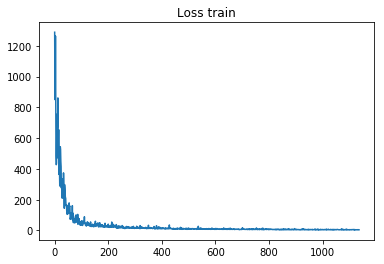


1 epoch: train loss 2.435384
val loss: 0.97008365 test loss:  1.0120779

2 epoch: train loss 1.6255924
val loss: 0.54575133 test loss:  0.5662366

3 epoch: train loss 1.1557794
val loss: 0.38168365 test loss:  0.39525133

4 epoch: train loss 0.8742475
val loss: 0.28855112 test loss:  0.29519165

5 epoch: train loss 0.6647022
val loss: 0.22967389 test loss:  0.23249584

6 epoch: train loss 0.5525572
val loss: 0.18690726 test loss:  0.18912335

7 epoch: train loss 0.46229717
val loss: 0.1573903 test loss:  0.16021706

8 epoch: train loss 0.4129285
val loss: 0.13886586 test loss:  0.14095624

9 epoch: train loss 0.35586655
val loss: 0.124268115 test loss:  0.12594672

10 epoch: train loss 0.32826474
val loss: 0.11218623 test loss:  0.11346724


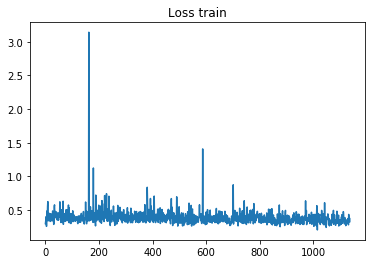


11 epoch: train loss 0.29907763
val loss: 0.10357304 test loss:  0.10578393

12 epoch: train loss 0.27183375
val loss: 0.09728654 test loss:  0.09957377

13 epoch: train loss 0.24686785
val loss: 0.09180033 test loss:  0.094202235

14 epoch: train loss 0.22881368
val loss: 0.0876611 test loss:  0.09083038

15 epoch: train loss 0.21662736
val loss: 0.08375712 test loss:  0.08609967

16 epoch: train loss 0.20541573
val loss: 0.08098352 test loss:  0.08429974

17 epoch: train loss 0.19666205
val loss: 0.077686846 test loss:  0.079871185

18 epoch: train loss 0.18976998
val loss: 0.075046524 test loss:  0.078179225

19 epoch: train loss 0.18024117
val loss: 0.07336292 test loss:  0.07553489

20 epoch: train loss 0.17631933
val loss: 0.07232946 test loss:  0.0750228


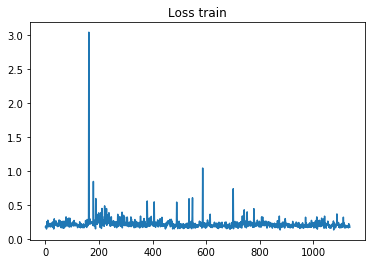


21 epoch: train loss 0.167674
val loss: 0.07035645 test loss:  0.07223323

22 epoch: train loss 0.16447748
val loss: 0.06853827 test loss:  0.071100764

23 epoch: train loss 0.15953116
val loss: 0.06704634 test loss:  0.068854384

24 epoch: train loss 0.1561475
val loss: 0.0670611 test loss:  0.06919074

25 epoch: train loss 0.15168561
val loss: 0.06475865 test loss:  0.066575065

26 epoch: train loss 0.15079987
val loss: 0.064058326 test loss:  0.06631695

27 epoch: train loss 0.14671466
val loss: 0.06291547 test loss:  0.064615756

28 epoch: train loss 0.14370556
val loss: 0.062122744 test loss:  0.063914575

29 epoch: train loss 0.13935126
val loss: 0.061199058 test loss:  0.06310568

30 epoch: train loss 0.13912545
val loss: 0.060805194 test loss:  0.062470797


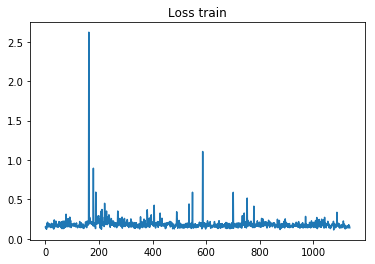


31 epoch: train loss 0.13400896
val loss: 0.060181182 test loss:  0.062108923

32 epoch: train loss 0.1334559
val loss: 0.06031239 test loss:  0.061663356

33 epoch: train loss 0.1311932
val loss: 0.058264118 test loss:  0.060303967

34 epoch: train loss 0.1310767
val loss: 0.059204128 test loss:  0.060401447

35 epoch: train loss 0.12798223
val loss: 0.05641265 test loss:  0.058422998

36 epoch: train loss 0.12691781
val loss: 0.057720732 test loss:  0.058756042

37 epoch: train loss 0.12603371
val loss: 0.054994717 test loss:  0.0566421

38 epoch: train loss 0.12307704
val loss: 0.05623247 test loss:  0.057267744

39 epoch: train loss 0.12423965
val loss: 0.054951943 test loss:  0.056442343

40 epoch: train loss 0.11770021
val loss: 0.055520605 test loss:  0.056407113


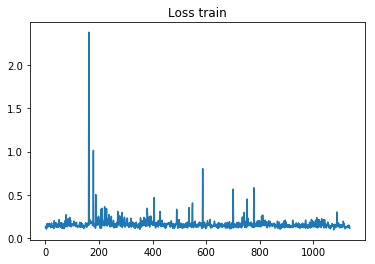


41 epoch: train loss 0.12156557
val loss: 0.05432897 test loss:  0.05548703

42 epoch: train loss 0.11542751
val loss: 0.05367959 test loss:  0.054634366

43 epoch: train loss 0.118915774
val loss: 0.05421644 test loss:  0.05533092

44 epoch: train loss 0.11335821
val loss: 0.05290946 test loss:  0.05379792

45 epoch: train loss 0.11544869
val loss: 0.052662015 test loss:  0.05362116

46 epoch: train loss 0.11105537
val loss: 0.052100983 test loss:  0.053021282

47 epoch: train loss 0.11182592
val loss: 0.051514655 test loss:  0.052692726

48 epoch: train loss 0.10892041
val loss: 0.051708914 test loss:  0.052611474

49 epoch: train loss 0.10938644
val loss: 0.05054549 test loss:  0.051585946

iter 0
mean return 3221.231864958423
std of return 0.0

iter 1
mean return 2545.78857924943
std of return 675.4432857089934

iter 2
mean return 1974.3074063998808
std of return 978.4327007937574

iter 3
mean return 2068.867531256934
std of return 863.0311489893453

iter 4
mean return 1955.786181

In [47]:
# 5. train nn with new dataset and check the performance
seed, it_num, batch_size, epoch, num_rollouts = 1, 1e+5, 100, 50, 25
batch_size2  =  int(batch_size/3)
set_seed(seed)
sess = get_session()
env = gym.make(game)

# 5-1. train from human(expert) Data
sess, state, action, out = train_nn(seed, num_state, sess, num_action, it_num, batch_size, batch_size2, epoch, new_xt, new_yt, x_val, y_val, x_test, y_test)

# 5-2. run trained policy to get dataset D_pi
returns2 = eval_policy(game, 25, sess, state, out, env, data_gen = False, verbose = True)


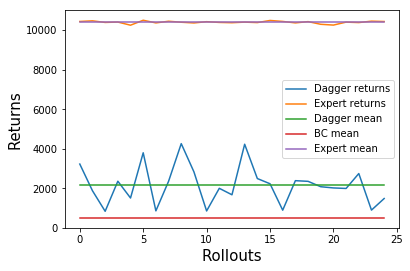

<Figure size 432x288 with 0 Axes>

In [48]:
# plot returns of BC and experts
plt.xlabel('Rollouts', size=15)
plt.ylabel('Returns',size =15)
expert = [10438.186857983954, 10471.131848812303, 10389.244896091363, 10408.525369725054, 10249.73483750236, 10500.494293676069, 10365.63592228353, 10449.819812393624, 10399.94066843901, 10362.921788183248, 10427.754227585881, 10389.807021159531, 10375.111270627773, 10405.069458543141, 10381.935291587313, 10489.363191346045, 10440.62519389299, 10365.833474975829, 10430.640306509, 10295.54458154796, 10255.717391407743, 10405.162307972787, 10382.36730720193, 10454.536386206888, 10436.20845939734]
plt.plot(returns2, label = 'Dagger returns')
plt.plot(expert,label = 'Expert returns')

plt.plot(np.mean(returns2)*np.ones((25,)), label = 'Dagger mean')
plt.plot(np.mean(returns)*np.ones((25,)), label = 'BC mean')
plt.plot(np.mean(expert)*np.ones((25,)), label = 'Expert mean')
plt.legend()
plt.figure()
plt.show()

In [2]:
env_name = ['Ant-v2', 'HalfCheetah-v2', 'Hopper-v2', 'Humanoid-v2', 'Reacher-v2', 'Walker2d-v2']
for game in env_name:
    env = gym.make(game)
    s = env.reset()
    print(game, s.shape, env.action_space) #env.action_space.sample())
    print(s)
    break

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Ant-v2 (111,) Box(8,)
[ 0.76829022  0.99905635 -0.03564569  0.00944792  0.02294638 -0.08854556
  0.04886376 -0.03778918 -0.07935118  0.07165854 -0.03556195 -0.03706296
  0.00199114 -0.02471657 -0.13279679  0.0085928   0.25811281 -0.08082821
  0.00152756 -0.11400017  0.05902827  0.14265744  0.05520232 -0.03390429
  0.08669324  0.00831578 -0.01825213  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.     

In [65]:
s1 = s.reshape(1, -1)
s3 = np.concatenate([s1, s1])
s3.shape
s4 = np.concatenate([s3, s1])
s4.shape

(3, 111)

In [62]:
# split data, create env
data = 'Humanoid-v2'
game = 'Humanoid-v2'
x_train, y_train, x_val, y_val, x_test, y_test, num_action, num_state = load_split_data(data, game)

observation (99116, 376)
action (99116, 1, 17)

observation example 
 [ 1.40860066e+00  9.99910652e-01  8.83546375e-03  7.20973686e-03
 -6.97442782e-03 -6.24027339e-03 -3.73320168e-03  1.96230558e-04
 -2.94829374e-04  5.43631535e-04  7.89400695e-03 -3.96659572e-03
  1.65940475e-03 -2.87733092e-04 -3.42465867e-03 -3.17347154e-03
  2.45280756e-03  1.80824279e-03 -8.29069650e-03  7.19337362e-03
 -7.36138149e-03  1.83741948e-03 -7.79378323e-03  3.87770805e-04
 -4.38850272e-03  4.87541352e-03 -1.02975546e-03 -9.10125980e-03
 -4.94717264e-03  7.28535167e-03 -2.30589161e-03  7.17455290e-03
 -9.06063946e-03 -9.38821466e-03 -5.49849485e-03  8.82943497e-03
 -3.75357679e-04  2.53766605e-03 -1.10504105e-03  1.45677320e-03
  5.71027385e-03  3.72505365e-03  2.18700651e-03 -8.87038373e-04
 -2.63120874e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  2.23166505e+00
  2.22092894e+00  3.


0 epoch: train loss 3.0215003
val loss: 40.659687 test loss:  34.903893


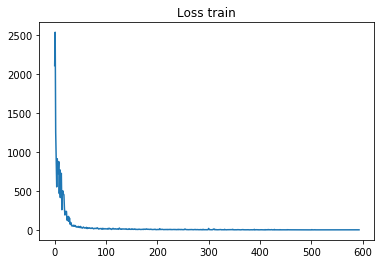


1 epoch: train loss 1.5908301
val loss: 1.7097937 test loss:  3.398336

2 epoch: train loss 1.0937729
val loss: 1.0133953 test loss:  2.7267365

3 epoch: train loss 0.8467661
val loss: 0.7431533 test loss:  2.4839313

4 epoch: train loss 0.70854837
val loss: 0.6047677 test loss:  2.361357

5 epoch: train loss 0.601236
val loss: 0.5224563 test loss:  2.2967954

6 epoch: train loss 0.5161441
val loss: 0.47303912 test loss:  2.2548015

7 epoch: train loss 0.43429637
val loss: 0.42821607 test loss:  2.2231913

8 epoch: train loss 0.3884354
val loss: 0.3953804 test loss:  2.191698

9 epoch: train loss 0.3456435
val loss: 0.36236706 test loss:  2.1682906

10 epoch: train loss 0.32196516
val loss: 0.35596436 test loss:  2.15961


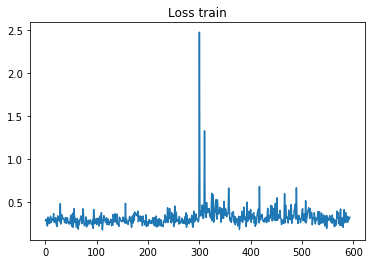


11 epoch: train loss 0.3262915
val loss: 0.32863727 test loss:  2.1435921

12 epoch: train loss 0.3215853
val loss: 0.31649062 test loss:  2.126805

13 epoch: train loss 0.30139104
val loss: 0.29785246 test loss:  2.117329

14 epoch: train loss 0.30866754
val loss: 0.29075125 test loss:  2.106117

15 epoch: train loss 0.27487335
val loss: 0.2745956 test loss:  2.0951066

16 epoch: train loss 0.2709276
val loss: 0.27056727 test loss:  2.1001236

17 epoch: train loss 0.24693668
val loss: 0.2568327 test loss:  2.0802536

18 epoch: train loss 0.232476
val loss: 0.2508894 test loss:  2.0875227

19 epoch: train loss 0.22841436
val loss: 0.23996395 test loss:  2.066573

20 epoch: train loss 0.20735337
val loss: 0.23687944 test loss:  2.0775335


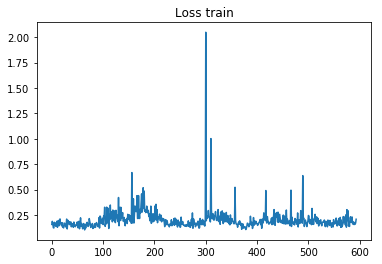


21 epoch: train loss 0.21498995
val loss: 0.23036301 test loss:  2.0600638

22 epoch: train loss 0.19661722
val loss: 0.23307194 test loss:  2.0720613

23 epoch: train loss 0.20955664
val loss: 0.21243277 test loss:  2.049355

24 epoch: train loss 0.20651956
val loss: 0.2195327 test loss:  2.0590303

25 epoch: train loss 0.18023323
val loss: 0.21280767 test loss:  2.0516052

26 epoch: train loss 0.20044161
val loss: 0.20483491 test loss:  2.0412638

27 epoch: train loss 0.1720491
val loss: 0.20474282 test loss:  2.0460334

28 epoch: train loss 0.18845387
val loss: 0.19972588 test loss:  2.0416949

29 epoch: train loss 0.14663087
val loss: 0.20065431 test loss:  2.0442517

30 epoch: train loss 0.15855432
val loss: 0.2061627 test loss:  2.056972


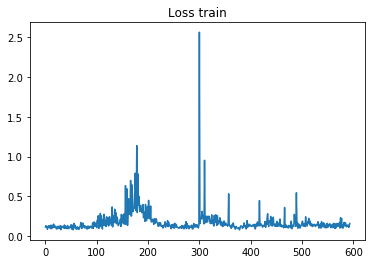


31 epoch: train loss 0.16732025
val loss: 0.19043891 test loss:  2.0341477

32 epoch: train loss 0.13583057
val loss: 0.19689992 test loss:  2.0460482

33 epoch: train loss 0.1485082
val loss: 0.18552817 test loss:  2.0316854

34 epoch: train loss 0.123255946
val loss: 0.18874376 test loss:  2.0370686

35 epoch: train loss 0.1340694
val loss: 0.17985098 test loss:  2.0261269

36 epoch: train loss 0.12914185
val loss: 0.19338627 test loss:  2.0420933

37 epoch: train loss 0.15371585
val loss: 0.16401035 test loss:  2.0098045

38 epoch: train loss 0.12302641
val loss: 0.18683195 test loss:  2.033867

39 epoch: train loss 0.1307237
val loss: 0.16782404 test loss:  2.017514

40 epoch: train loss 0.13127206
val loss: 0.17796837 test loss:  2.027227


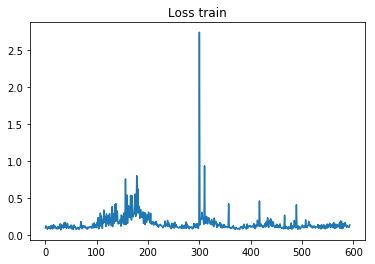


41 epoch: train loss 0.11882072
val loss: 0.16410089 test loss:  2.015755

42 epoch: train loss 0.13767354
val loss: 0.17336324 test loss:  2.025827

43 epoch: train loss 0.13321479
val loss: 0.17187123 test loss:  2.0238774

44 epoch: train loss 0.13245147
val loss: 0.16019835 test loss:  2.01172

45 epoch: train loss 0.14725961
val loss: 0.18485154 test loss:  2.0435069

46 epoch: train loss 0.10651854
val loss: 0.15092982 test loss:  2.0009165

47 epoch: train loss 0.12740798
val loss: 0.15692748 test loss:  2.0094194

48 epoch: train loss 0.106374845
val loss: 0.16182809 test loss:  2.0136693

49 epoch: train loss 0.11602574
val loss: 0.16949955 test loss:  2.0234704


In [70]:
# training deep neural nets
set_seed(1)
sess = get_session()
state, action, out = model(num_state, num_action)
mean_loss = loss_function(out, action)
train_step = optimizer(mean_loss)
        
var= tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
sess.run(tf.global_variables_initializer())    

it_num = int(1e+5)
batch_size = 100
batch_size2 = 30
epoch = 50

for i in range(epoch):
    loss_his, loss_his2, loss_his3 = [], [], []
    for j in range(int(x_train.shape[0]/batch_size)):
        _, loss_train = sess.run([train_step, mean_loss], feed_dict={state:x_train[j*batch_size:(j+1)*batch_size]
                                                                                , action:y_train[j*batch_size:(j+1)*batch_size]})
        loss_his.append(loss_train)
        
        loss_val = sess.run([mean_loss], feed_dict={state:x_val[j*batch_size2:(j+1)*batch_size2]
                                                                                , action:y_val[j*batch_size2:(j+1)*batch_size2]})
        loss_test = sess.run([mean_loss], feed_dict={state:x_test[j*batch_size2:(j+1)*batch_size2]
                                                                                , action:y_test[j*batch_size2:(j+1)*batch_size2]})
        loss_his2.append(loss_val)
        loss_his3.append(loss_test)
        
    print('\n'+str(i)+' epoch: '+'train loss', loss_train)
    print('val loss: '+ str(np.mean(np.array(loss_his2)))+' test loss: ',str(np.mean(np.array(loss_his3))) )
    if i % 10 == 0:
        plt.plot(loss_his)
        plt.title('Loss train')
        plt.show()

In [71]:
# evaluate policy
env = gym.make(game)
num_rollouts = 25
returns = []

for i in range(num_rollouts):
    print('\niter', i)
    obs = env.reset()
    done = False
    totalr = 0.
    steps = 0
    while not done:
        action = sess.run(out, feed_dict={state:obs.reshape(1, -1)})
        obs, r, done, _ = env.step(action)
        totalr += r
        steps += 1
        #env.render()
    returns.append(totalr)

    print('mean return', np.mean(returns))
    print('std of return', np.std(returns))

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.

iter 0
mean return 487.15995599174835
std of return 0.0

iter 1
mean return 689.036597109694
std of return 201.8766411179456

iter 2
mean return 653.0875599530127
std of return 172.49382220153305

iter 3
mean return 598.6441237175287
std of return 176.65744329252652

iter 4
mean return 870.834056296106
std of return 566.847174646786

iter 5
mean return 848.8602943443537
std of return 519.7858506883048

iter 6
mean return 824.0103333080197
std of return 485.0625654964369

iter 7
mean return 770.0483592517392
std of return 475.6661049503021

iter 8
mean return 760.341610599764
std of return 449.30191000224676

iter 9
mean return 718.3531746294055
std of return 444.4684966289875

iter 10
mean return 750.6542939920129
std of return 435.92037422246966

iter 11
mean return 737.8306103236982
std o